# Data loading, cleanup and processing

The first step to a ML project is to obtain the dataset you will be working with. 
There are many repositories for materials science-specific data (whether online or offline)---consult the accompanying paper for a list of the more commonly used ones.

Once you have identified the repository and dataset you will use for your project, you will have to download it to your local machine, or establish a way to reliably access the dataset.
Consult the documentation of the repository for how to do this.

For this tutorial, we have collected heat capacity ($C_p$) data from the [NIST-JANAF Thermochemical Tables](https://doi.org/10.18434/T42S31).

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

#from pandas_profiling import ProfileReport
from ydata_profiling import ProfileReport

/Users/ndtrung/Codes/BestPractices/mat-design/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data

Using Pandas, we read in the dataset into a DataFrame. 

We also print the shape of the DataFrame, which indicates the number of rows and columns in this dataset.

In [7]:
PATH = os.getcwd()
data_path = os.path.join(PATH, '../data/cp_data_demo.csv')

df = pd.read_csv(data_path)
print(f'Original DataFrame shape: {df.shape}')

Original DataFrame shape: (4583, 3)


This means that our input dataset has 4583 data samples, each with 3 variables.

## Examine the data

We examine some rows and look at the data's basic statistics.

We see that the dataset contains information about the formula, measurement condition (in this case, temperature in K), and the target property, heat capacity (in J/(mol * K)).

In [9]:
df.head(10)

,FORMULA,CONDITION: Temperature (K),PROPERTY: Heat Capacity (J/mol K)
0,B2O3,1400.0,134.306
1,B2O3,1300.0,131.294
2,B2O3,1200.0,128.072
3,B2O3,1100.0,124.516
4,B2O3,1000.0,120.625
5,B2O3,900.0,116.190
6,B2O3,800.0,111.169
7,B2O3,723.0,106.692
8,B2O3,700.0,105.228
9,B2O3,600.0,98.115


First thing you should notice: we have many observations of the same compound (B2O3) but measured at different measurement conditions, resulting in a different property value.

We can get some simple summary statistics of the DataFrame by calling the `.describe()` method on the database.

In [10]:
df.describe()

,CONDITION: Temperature (K),PROPERTY: Heat Capacity (J/mol K)
count,4579.000000,4576.000000
mean,1170.920341,107.483627
std,741.254366,67.019055
min,-2000.000000,-102.215000
25%,600.000000,61.312500
50%,1000.000000,89.497000
75%,1600.000000,135.645000
max,4700.000000,494.967000


Using the `pandas-profiling` library, we can generate a more in-depth report of our starting dataset.
Note that generating this profile report might take upwards of 20 seconds.

Summarize dataset:  71%|█████████████████████████▍          | 12/17 [00:00<00:00, 63.25it/s, Missing diagram heatmap]/Users/ndtrung/Codes/BestPractices/mat-design/lib/python3.12/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)
/Users/ndtrung/Codes/BestPractices/mat-design/lib/python3.12/site-packages/ydata_profiling/model/missing.py:78: UserWarning: There was an attempt to generate the Heatmap missing values diagrams, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(missing_diagrams={"Heatmap": False}`)
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/ydata-profiling/issues
(include the error message: 'could not convert string to float: '--'')
  warnings.warn(
Generate report structure: 100%|██████████████████████████████████████████████

ModuleNotFoundError: No module named 'ipywidgets'

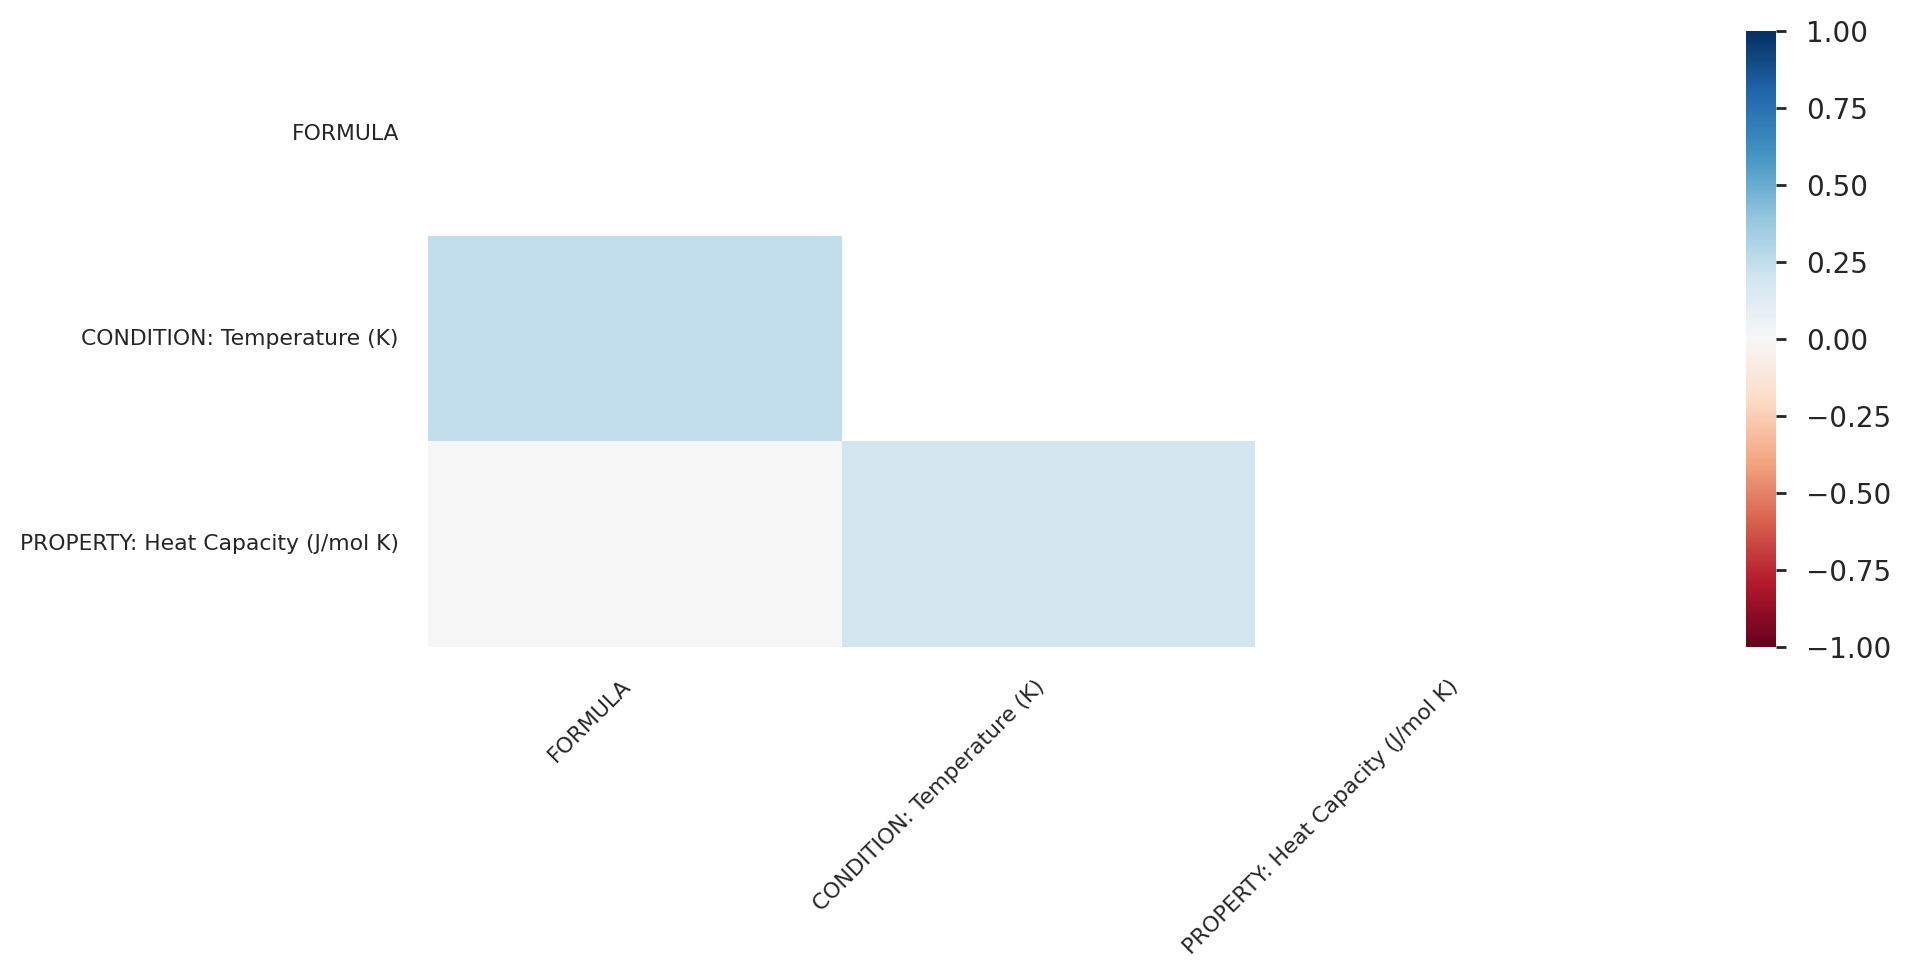

In [11]:
profile = ProfileReport(df.copy(), title='Pandas Profiling Report of Cp dataset', html={'style':{'full_width':True}})
profile.to_widgets()

Notice a few things from the profile report:
* We have some missing cells in the dataset ("Overview" tab)
* We have some unrealistic Temperature and Heat Capacity values in the dataset ("Variables" tab)
* We have some missing Temperature, Formula and Heat Capacity values in the dataset ("Variables" tab)

Also notice that on the "Overview" tab, there is the following warning: `FORMULA` has a high cardinality: 245 distinct values.

Cardinality is the number of distinct values in a column of a table, relative to the number of rows in the table.
In our dataset, we have a total of 4583 data observations, but only 245 distinct formulae.
We will have to keep this in mind later, when we process and split the dataset.

## Rename the column names for brevity

In [12]:
df.columns

Index(['FORMULA', 'CONDITION: Temperature (K)',
       'PROPERTY: Heat Capacity (J/mol K)'],
      dtype='object')

In [13]:
rename_dict = {'FORMULA': 'formula',
               'CONDITION: Temperature (K)': 'T',
               'PROPERTY: Heat Capacity (J/mol K)': 'Cp'}
df = df.rename(columns=rename_dict)
df.columns

Index(['formula', 'T', 'Cp'], dtype='object')

## Check for and remove `NaN` values

Here we can use the built-in Pandas methods to check for `NaN` values in the dataset, which are missing values.
We then remove the dataset rows which contain `NaN` values.

In [14]:
# Check for NaNs in the respective dataset columns, and get the indices
df2 = df.copy()
bool_nans_formula = df2['formula'].isnull()
bool_nans_T = df2['T'].isnull()
bool_nans_Cp = df2['Cp'].isnull()

# Drop the rows of the DataFrame which contain NaNs
df2 = df2.drop(df2.loc[bool_nans_formula].index, axis=0)
df2 = df2.drop(df2.loc[bool_nans_T].index, axis=0)
df2 = df2.drop(df2.loc[bool_nans_Cp].index, axis=0)

print(f'DataFrame shape before dropping NaNs: {df.shape}')
print(f'DataFrame shape after dropping NaNs: {df2.shape}')

DataFrame shape before dropping NaNs: (4583, 3)
DataFrame shape after dropping NaNs: (4570, 3)


Pandas also includes the convenient built-in method `.dropna()` to check for and remove `NaNs` in-place:

In [15]:
df3 = df.copy()
df3 = df3.dropna(axis=0, how='any')

print(f'DataFrame shape before dropping NaNs: {df.shape}')
print(f'DataFrame shape after dropping NaNs: {df3.shape}')

df = df3.copy()

DataFrame shape before dropping NaNs: (4583, 3)
DataFrame shape after dropping NaNs: (4570, 3)


## Check for and remove unrealistic values

In some cases, you might also get data values that simply don't make sense.
For our dase, this could be negative values in the temperature or heat capacity values.

In [16]:
bool_invalid_T = df['T'] < 0
bool_invalid_Cp = df['Cp'] < 0

df = df.drop(df.loc[bool_invalid_T].index, axis=0)
df = df.drop(df.loc[bool_invalid_Cp].index, axis=0)

print(f'Cleaned DataFrame shape: {df.shape}')

Cleaned DataFrame shape: (4564, 3)


## Save cleaned data to csv

Finally, after cleaning and processing the data, you can save it to disk in a cleaned state for you to use later.

Pandas allows us to save our data as a comma separated value `.csv` file. 

In [17]:
out_path = os.path.join(PATH, '../data/cp_data_cleaned.csv')
df.to_csv(out_path, index=False)

Note, your data can be saved in other file formats (such as hdf5) or in databases (such as SQL), but we will not go into the details of these formats.

Typically, the amount of data you can gather for your ML project isn't large enough to warrant these approaches.